###Fruit fly Cracker

In [2]:
import os
import pandas as pd
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier as random_forest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np


import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import svm

%matplotlib inline


In [256]:
#Setting working directory
#os.chdir('/Users/emin/Downloads/Lab4/lab/')
#Read the fiji features
df_ = pd.read_csv("All_Features.csv")
#Read the embryo labels
df_el = pd.read_csv('embryo_labels.csv')
#del df_['Unnamed: 0']
del df_el['Unnamed: 0']

In [6]:
sum(np.array(df_el.embryo_id) == np.array(df_['Unnamed: 0'].map(lambda x: x/1000)))/len(np.array(df_el.embryo_id))

1

In [257]:
#reading the spatial data
spatial_train = pd.read_csv('spatial_train.csv')
spatial_test = pd.read_csv('spatial_test.csv')
n_cols = len(spatial_train.columns)-1

#Get the spatial training data (features and labels)
X_train = spatial_train.ix[:,range(n_cols)]
y_train = spatial_train.ix[:,-1]

#Get the testing training data (features and labels)
X_test = spatial_test.ix[:,range(n_cols)]
y_true = spatial_test.ix[:,-1]

In [259]:
len(y_train)

28758

In [8]:
print 'We have ' + str(len(X_train)) + ' training observations'
print 'We have ' + str(len(X_test)) + ' testing observations'
df_train = df_[0:28758]
df_test = df_[28758:]

We have 28758 training observations
We have 3906 testing observations


In [9]:
#A simple null check to see if everything is right
sum(pd.isnull(df_test.Kurtosis1))

0

In [10]:
#add the x, y and the distance features
df_train['x'] = X_train.x
df_train['y'] = X_train.y
df_train['distance'] = X_train.distance
df_test.index = range(len(df_test))
df_test['x'] = X_test.x
df_test['y'] = X_test.y
df_test['distance'] = X_test.distance

/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [6]:
#Here I will create some dummy fiji features to demonstrate how this module works:
#Uncomment the new_fijis and comment the dummy fijis to add ur own fiji features
#The fiji features u are adding should be in CSV
#Also note that the length of training and testing should be the same as above. Take care
#with mapping the correct superpixel fiji features :)

#new_fijis_train = pd.csv('fiji_train_file.csv')
#new_fijis_test = pd.csv('fiji_test_file.csv')

#dummy_fiji_train = pd.DataFrame(data = np.random.randint(low=0,high=10,size=(28758,2)))
#dummy_fiji_test = pd.DataFrame(data = np.random.randint(low=0,high=10,size=(3906,2)))

In [42]:
#Again swap the comments
#n_cols_dummy_fiji = len(dummy_fiji_train.columns)
#col_names = ['fiji '+str(name) for name in range(n_cols_dummy_fiji)]
#X_train[col_names] = dummy_fiji_train
#X_test[col_names] = dummy_fiji_test

#n_cols_fiji = len(new_fijis.columns) #getting the names of the fiji feature columns
#col_names = ['fiji '+str(name) for name in range(n_cols_fiji)] # Cooking new names
#X_train[col_names] = new_fijis_train # Inserting the new columns to the spatial data sets
#X_test[col_names] = new_fijis_test 

In [43]:
#See new features added:
df_.head()

,Unnamed: 0,Mean1,Mean2,Mean3,Mean4,Mean5,Mean6,Mean7,Mean8,Mean9,...,Kurtosis4,Kurtosis5,Kurtosis6,Kurtosis7,Kurtosis8,Kurtosis9,Kurtosis10,Kurtosis11,Kurtosis12,Kurtosis13
0,131072,10,-103,0,9,7,0,0,0,0,...,6,1,1,0,0,0,0,1,0,-1
1,131073,-6,-184,0,24,20,0,0,0,1,...,19,7,2,0,0,0,0,0,0,0
2,131074,-14,-77,0,6,6,0,0,0,-4,...,9,2,3,0,0,0,-1,5,-1,-1
3,131075,9,-132,0,29,25,0,0,0,4,...,2,0,0,0,0,0,0,-1,0,0
4,131076,-13,-175,0,23,19,0,0,0,0,...,7,0,0,0,0,0,0,0,2,2


In [132]:
len(df_['Unnamed: 0'].map(lambda x: x/1000).unique())


170

In [118]:
len(df_train['Unnamed: 0'].map(lambda x: x/1000).unique())



152

/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [12]:
"""
This basically predicts the purity of the pixel neighbhours
For every pixel, if all of its neighbohrs had the same label
then the weight would be one
this is done that way to accomodate the fact that at the boundaries 
the trust in the measurement is not that accurate
"""

#Prep the grouping by embryo
len(df_train['Unnamed: 0'].map(lambda x: x/1000).unique())
df_train['embryo_id'] = df_train['Unnamed: 0'].map(lambda x: x/1000)
grouped_by_embryo = df_train.groupby('embryo_id')
df_train['label'] = y_train

##Initialize the weights 
df_train['weight'] = np.zeros(len(df_train))+2


#For every embryoo define a knn to use for weighting
for embryo_id, group in grouped_by_embryo:
    X = group.ix[:,['x','y']]
    y = group.ix[:,'label']
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X, y) 
    print embryo_id
    #print group
    for s_pixel_i in range(len(group)):
        s_pixel = group.iloc[s_pixel_i,:]
        grand_index =  group.index[s_pixel_i]
        #print(neigh.predict([s_pixel['x'],s_pixel['y']]))
        #print neigh.classes_
        #print "PROB"
        W_i = neigh.predict_proba([s_pixel['x'],s_pixel['y']])[0][s_pixel['label']-1]
        df_train.loc[grand_index,'weight'] =  W_i
        #if s_pixel_i>10:
        #    break
        


/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: h

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


/Users/fadikfoury/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
#Assign the weight vector to a differnt array
W = df_train['weight']

In [14]:
#Delete the extranous fields
del df_train['label']
del df_train['weight']
del df_train['Unnamed: 0']
del df_train['embryo_id']
del df_test['Unnamed: 0']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cad69d0>]], dtype=object)

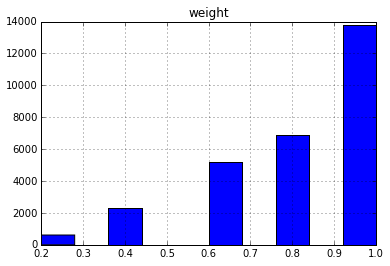

In [61]:
pd.DataFrame(W,columns=['weight']).hist()

In [65]:
y_train

0        3
1        1
2        1
3        1
4        1
5        1
6        2
7        1
8        1
9        1
10       3
11       1
12       1
13       1
14       2
15       2
16       3
17       1
18       2
19       1
20       3
21       1
22       3
23       2
24       1
25       2
26       2
27       2
28       1
29       3
        ..
28728    2
28729    1
28730    1
28731    2
28732    2
28733    1
28734    3
28735    1
28736    3
28737    1
28738    2
28739    3
28740    1
28741    1
28742    3
28743    2
28744    2
28745    3
28746    1
28747    1
28748    2
28749    2
28750    3
28751    3
28752    1
28753    1
28754    1
28755    1
28756    1
28757    1
Name: label, dtype: int64

# Features Selection

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [121]:
corr_matrix = np.corrcoef(df_train.values.T)

In [189]:
cut_i = 30
b = []
for a in df_train.ix[:,cut_i:].columns:
    b.append(a[0])
    

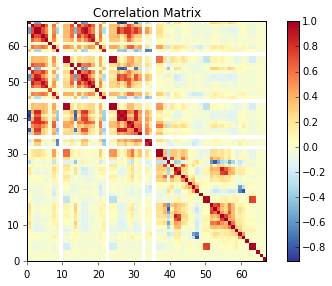

In [190]:
corr_matrix = np.corrcoef(df_train.ix[:,1:70].values.T)
sm.graphics.plot_corr(corr_matrix)
plt.show()

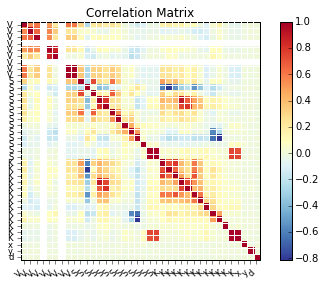

In [192]:
corr_matrix = np.corrcoef(df_train.ix[:,cut_i:].values.T)
fig = sm.graphics.plot_corr(corr_matrix,xnames=b)
plt.show()

#Weighted SVM

## Spatial Features

In [200]:
clf = svm.SVC()
clf.fit(df_train.ix[:,['x', 'y', 'distance']], y_train,sample_weight=W)

y_pred = clf.predict(df_test.ix[:,['x', 'y', 'distance']] )

#Forming a confusion matrix
cm_WSVMSF = confusion_matrix(y_true,y_pred)
accuracy_score(y_true, y_pred)

0.54249871991807475

### An SVM Driven Decision Stump

we propose a tree based SVM, 
first split determines the border (SVM 1)
end nodes determine which SVM to use (SVM_innder, SVM_outer)

In [229]:
#Border SVM (isBorder == 0)

clf = svm.SVC()
clf.fit(df_train.ix[:,['x', 'y', 'distance']], W>0.9)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [230]:
y_pred = clf.predict(df_train.ix[:,['x', 'y', 'distance']])

In [316]:
#Training Error, of our first split classifier
sum(y_pred == (W>0.9))/float(len(W))

ValueError: Lengths must match to compare

In [317]:
clf

NameError: name 'clf' is not defined

0.2
0.4
0.6
0.9


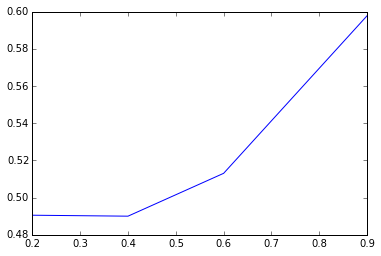

In [325]:
accuracy_list = []
for w_cut_off in [0.2,0.4,0.6,0.9]:
    #Train an inner SVM
    print w_cut_off
    clf_inner = svm.SVC()
    clf_inner.fit(df_train.ix[:,['x', 'y', 'distance']][W>w_cut_off], y_train[W>w_cut_off])
    y_pred_inner = clf_inner.predict(df_test.ix[:,['x', 'y', 'distance']])


    clf_outer = svm.SVC()
    clf_outer.fit(df_train.ix[:,['x', 'y', 'distance']][W<=w_cut_off], y_train[W<=w_cut_off])
    y_pred_outer = clf_outer.predict(df_test.ix[:,['x', 'y', 'distance']])
    
    y_predict_label = clf.predict(df_test.ix[:,['x', 'y', 'distance']])
    
    y_predict_final = (y_predict_label==1)*y_pred_inner + (1-(y_predict_label==1))*y_pred_outer
    
    (y_predict_label==1)*y_pred_inner
    
    acc = accuracy_score(y_true, y_predict_final)
    accuracy_list.append([w_cut_off,float(acc)])
    
a = plt.plot(np.array(accuracy_list)[:,0],np.array(accuracy_list)[:,1])

0.2
0.4
0.6
0.9


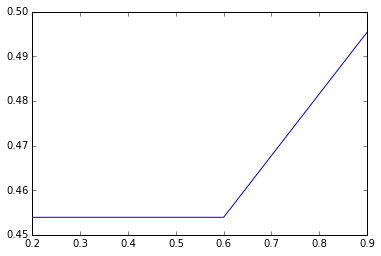

In [327]:
accuracy_list = []
for w_cut_off in [0.2,0.4,0.6,0.9]:
    #Train an inner SVM
    print w_cut_off
    clf_inner = svm.SVC()
    clf_inner.fit(df_train.ix[:,:][W>w_cut_off], y_train[W>w_cut_off])
    y_pred_inner = clf_inner.predict(df_test.ix[:,:])


    clf_outer = svm.SVC()
    clf_outer.fit(df_train.ix[:,:][W<=w_cut_off], y_train[W<=w_cut_off])
    y_pred_outer = clf_outer.predict(df_test.ix[:,:])
    
    y_predict_label = clf.predict(df_test.ix[:,['x', 'y', 'distance']])
    
    y_predict_final = (y_predict_label==1)*y_pred_inner + (1-(y_predict_label==1))*y_pred_outer
    
    (y_predict_label==1)*y_pred_inner
    
    acc = accuracy_score(y_true, y_predict_final)
    accuracy_list.append([w_cut_off,float(acc)])
    
a = plt.plot(np.array(accuracy_list)[:,0],np.array(accuracy_list)[:,1])

In [329]:
#Train an inner SVM
w_cut_off = 0.9
clf_inner = svm.SVC()
clf_inner.fit(df_train.ix[:,['x', 'y', 'distance']][W>w_cut_off], y_train[W>w_cut_off])
y_pred_inner = clf_inner.predict(df_test.ix[:,['x', 'y', 'distance']])


clf_outer = svm.SVC()
clf_outer.fit(df_train.ix[:,30:][W<=w_cut_off], y_train[W<=w_cut_off])
y_pred_outer = clf_outer.predict(df_test.ix[:,30:])

y_predict_label = clf.predict(df_test.ix[:,['x', 'y', 'distance']])

y_predict_final = (y_predict_label==1)*y_pred_inner + (1-(y_predict_label==1))*y_pred_outer

(y_predict_label==1)*y_pred_inner

acc = accuracy_score(y_true, y_predict_final)
acc

0.51510496671786998

In [330]:
#Not much improvement 

# Non - Weighted SVM

## Spatial Features

In [198]:
clf = svm.SVC()
clf.fit(df_train.ix[:,['x', 'y', 'distance']], y_train)

y_pred = clf.predict(df_test.ix[:,['x', 'y', 'distance']])

#Forming a confusion matrix
cm_NWSVMSF = confusion_matrix(y_true,y_pred)
accuracy_score(y_true, y_pred)

0.58013312852022525

## Features Selected Based on Corr Plot

In [194]:
clf = svm.SVC()
clf.fit(df_train.ix[:,cut_i:], y_train)

y_pred = clf.predict(df_test.ix[:,cut_i:])

#Forming a confusion matrix
cm = confusion_matrix(y_true,y_pred)
accuracy_score(y_true, y_pred)



0.49539170506912444

Notice that the selected features confused the SVM, teh accuracy dropped from 60 to 50 % 

It seems that the features selection utilizing correlation is performing poorly; hence, we are going to hand over the feature selection proccess to random forest. We will be picking the best features based on random forest features importance histogram.

We will be running two random forests on the entire data set:
- A weighted random forest
- A non-weighted random forest

The best model will be chosen based on the testing set accuracy.

The best model will then be used to to pick the best 30 features (Spatial and Fiji)

# Using Random Forest For Feature Selection

In [342]:
#running Random forest
forest = random_forest(n_estimators = 10000, max_depth=50)
forest.fit(df_train.ix[:,:], y_train)
#Predicting
y_pred = forest.predict(df_test.ix[:,:])
accuracy_score(y_true, y_pred)

0.85483870967741937

In [1]:
indices

NameError: name 'indices' is not defined

In [368]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(df_test.columns)):
    print str("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])) + str(df_test.columns[indices[f]])
    

# Plot the feature importances of the forest
plt.figure()
#plt.title("Feature importances")
plt.bar(range(len(df_test.columns)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
#plt.xticks(range(len(df_test.columns)), df_test.columns)
plt.show()

Feature ranking:
1. feature 0 (0.334510)Mean1
2. feature 1 (0.186376)Mean2
3. feature 2 (0.164406)Mean3
4. feature 20 (0.022734)Median8
5. feature 3 (0.020272)Mean4
6. feature 4 (0.020174)Mean5
7. feature 6 (0.019426)Mean7
8. feature 5 (0.019175)Mean6
9. feature 7 (0.018765)Mean8
10. feature 8 (0.018354)Mean9
11. feature 9 (0.018192)Mean10
12. feature 10 (0.018168)Mean11
13. feature 11 (0.017150)Mean12
14. feature 12 (0.016793)Mean13
15. feature 17 (0.015504)Median5
16. feature 13 (0.015319)Median1
17. feature 19 (0.015202)Median7
18. feature 16 (0.015166)Median4
19. feature 15 (0.015033)Median3
20. feature 18 (0.014706)Median6
21. feature 14 (0.014575)Median2


IndexError: index 21 is out of bounds for axis 0 with size 21

In [333]:
best_column_features = indices[0:20]

0.84715821812596004

# Filtering Out The Best Features

In [369]:
#running Random forest
forest = random_forest(n_estimators = 1000, max_depth=50)
forest.fit(df_train.ix[:,best_column_features], y_train)
#Predicting
y_pred = forest.predict(df_test.ix[:,best_column_features])
accuracy_score(y_true, y_pred)
# We have an improvemnet in the random forest which is good! to 86.6

0.86712749615975426

In [352]:
#last trick here, feed in the SVM clf classifier to the random forest (0,1)

In [361]:
y_pred = clf.predict(df_train.ix[:,['x', 'y', 'distance']])
df_train_1 = df_train.ix[:,best_column_features]
df_train_1['SVM_f'] = y_pred

y_pred = clf.predict(df_test.ix[:,['x', 'y', 'distance']])
df_test_l = df_test.ix[:,best_column_features]
df_test_l['SVM_f'] = y_pred

/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/fadikfoury/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [363]:
#running Random forest, with SVM feature added
forest = random_forest(n_estimators = 1000, max_depth=50)
forest.fit(df_train_1, y_train)
#Predicting
y_pred = forest.predict(df_test_l)
accuracy_score(y_true, y_pred)
# We have an improvemnet in the random forest which is good! to 86.6

0.86175115207373276

In [365]:
df_train_1

,distance,x,y,Median1,Variance9,Mean1,Variance10,Variance5,Variance2,Median2,...,Variance1,Mean2,Median4,Variance3,Mean4,Median5,Median9,Mean5,Mean9,SVM_f
0,237.000000,564.063225,238.875687,10,25,10,10,21,11806,-91,...,32326,-103,6,6,9,6,0,7,0,True
1,63.031738,120.589947,200.251323,16,73,-6,27,351,50745,-128,...,103437,-184,14,20,24,15,2,20,1,False
2,50.921509,929.826923,498.230769,-6,15,-14,15,58,6839,-67,...,15054,-77,2,2,6,2,-4,6,-4,True
3,100.239716,195.250799,409.416933,29,259,9,72,427,21749,-112,...,53922,-132,13,11,29,17,-2,25,4,True
4,73.437050,735.015504,519.666667,2,107,-13,39,140,30379,-143,...,75031,-175,17,15,23,16,1,19,0,True
5,23.769728,245.507149,84.659964,10,47,80,6,1529,13553,-53,...,74470,-70,4,14,32,10,14,32,13,False
6,175.034286,477.419527,418.089349,34,135,74,53,4805,56728,-155,...,178305,-198,31,36,69,44,11,60,11,False
7,21.633308,1068.599622,138.400378,-8,29,-8,17,83,8700,-89,...,23230,-98,5,4,8,5,-4,7,-3,True
8,29.966648,47.799699,364.049699,29,21,8,5,98,14734,-42,...,28863,-79,2,5,8,3,6,8,5,False
9,24.596748,232.574038,511.016288,21,54,6,12,162,18962,-65,...,35338,-103,8,7,17,11,2,14,1,True


Feature ranking:
1. feature 0 (0.334510)distance
2. feature 1 (0.186376)x
3. feature 2 (0.164406)y
4. feature 20 (0.022734)SVM_f
5. feature 3 (0.020272)Median1
6. feature 4 (0.020174)Variance9
7. feature 6 (0.019426)Variance10
8. feature 5 (0.019175)Mean1
9. feature 7 (0.018765)Variance5
10. feature 8 (0.018354)Variance2
11. feature 9 (0.018192)Median2
12. feature 10 (0.018168)Variance4
13. feature 11 (0.017150)Variance1
14. feature 12 (0.016793)Mean2
15. feature 17 (0.015504)Median9
16. feature 13 (0.015319)Median4
17. feature 19 (0.015202)Mean9
18. feature 16 (0.015166)Median5
19. feature 15 (0.015033)Mean4
20. feature 18 (0.014706)Mean5
21. feature 14 (0.014575)Variance3


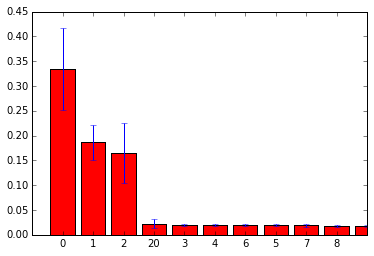

In [367]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(df_train_1.columns)):
    print str("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])) + str(df_train_1.columns[indices[f]])
    

# Plot the feature importances of the forest
plt.figure()
#plt.title("Feature importances")
plt.bar(range(len(df_train_1.columns)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
#plt.xticks(range(len(df_test.columns)), df_test.columns)
plt.show()

#### Filtering Further

In [374]:
imp = indices[:10]

In [372]:
#running Random forest, with SVM feature along with the spatial features
forest = random_forest(n_estimators = 1000, max_depth=50)
forest.fit(df_train_1.ix[:,['x', 'y', 'distance','SVM_f']], y_train)
#Predicting
y_pred = forest.predict(df_test_l.ix[:,['x', 'y', 'distance','SVM_f']])
accuracy_score(y_true, y_pred)
# We have an improvemnet in the random forest which is good! to 86.6

0.84050179211469533

In [375]:
#running Random forest, with SVM feature added along with the best 10
forest = random_forest(n_estimators = 1000, max_depth=50)
forest.fit(df_train_1.ix[:,imp], y_train)
#Predicting
y_pred = forest.predict(df_test_l.ix[:,imp])
accuracy_score(y_true, y_pred)
# We have an improvemnet in the random forest which is good! to 86.6

0.85867895545314898

    Non could beat the accuracy of 87 %, so now we have the top 20 Features to be best_column_features

In [3]:
best_column_features = np.array([67, 65, 66, 13, 34,  0, 35, 30, 27, 14, 29, 26,  1, 16, 28,  3, 17,
       21,  4,  8])

# Work with the best features

## Tunning Random Forest

In [379]:
#running Random forest
forest = random_forest(n_estimators = 1000, max_depth=50, n_jobs =-1)
forest.fit(df_train.ix[:,best_column_features], y_train)
#Predicting
y_pred = forest.predict(df_test.ix[:,best_column_features])
accuracy_score(y_true, y_pred)
# We have an improvemnet in the random forest which is good! to 86.6

[Parallel(n_jobs=4)]: Done   1 out of 1000 | elapsed:    0.1s remaining:  1.4min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   22.0s finished
[Parallel(n_jobs=4)]: Done   1 out of  42 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.86559139784946237

### Tunning  the splitting criterion

In [387]:
c_acc = []
for cri in ['gini', 'entropy']:
    forest = random_forest(n_estimators = 1000, max_depth=50, criterion=cri, n_jobs =-1)
    forest.fit(df_train.ix[:,best_column_features], y_train)
    #Predicting
    y_pred = forest.predict(df_test.ix[:,best_column_features])
    a = accuracy_score(y_true, y_pred)  
    c_acc.append([cri,float(a)])
    



In [388]:
c_acc

[['gini', 0.8661034306195596], ['entropy', 0.8661034306195596]]

### Tunning  the min per split criterion

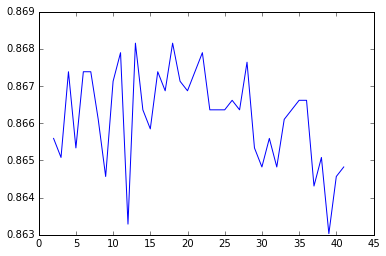

In [403]:
ms_acc = []
for min_s in range(40)+np.ones(40)*2:
    forest = random_forest(n_estimators = 1000, max_depth=50, min_samples_split = min_s, n_jobs =-1)
    forest.fit(df_train.ix[:,best_column_features], y_train)
    #Predicting
    y_pred = forest.predict(df_test.ix[:,best_column_features])
    a = accuracy_score(y_true, y_pred)  
    ms_acc.append([min_s,float(a)])
plt.plot(np.array(ms_acc)[:,0],np.array(ms_acc)[:,1])

### Tunning  the min per node criterion

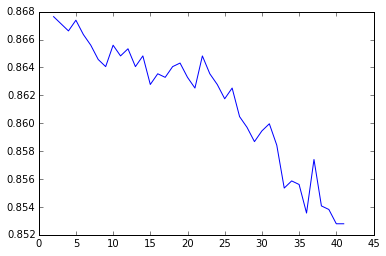

In [404]:
msl_acc = []
for min_sl in range(40)+np.ones(40)*2:
    forest = random_forest(n_estimators = 1000, max_depth=50, min_samples_leaf = min_sl, n_jobs =-1)
    forest.fit(df_train.ix[:,best_column_features], y_train)
    #Predicting
    y_pred = forest.predict(df_test.ix[:,best_column_features])
    a = accuracy_score(y_true, y_pred)  
    msl_acc.append([min_sl,float(a)])
plt.plot(np.array(msl_acc)[:,0],np.array(msl_acc)[:,1])

In [ ]:
#Chosen parameters, default for everything, except for the min_sample_split(19)

## Tunning SVM

## Tunning the kernel

In [ ]:
svmk_acc = [ 'poly', 'rbf', 'sigmoid']
for svmk in svmk_acc:
    svm_cls = svm.SVC(kernel=svmk)
    svm_cls.fit(df_train.ix[:,best_column_features], y_train)
    #Predicting
    y_pred = svm_cls.predict(df_test.ix[:,best_column_features])
    a = accuracy_score(y_true, y_pred)  
    svmk_acc.append([min_sl,float(a)])
plt.plot(np.array(svmk_acc)[:,0],np.array(svmk_acc)[:,1])

## Tunning the gamma

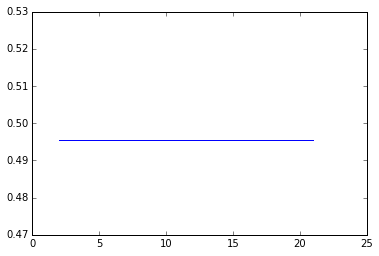

In [16]:
gamma_acc = []
for gamma_i in range(20)+np.ones(20)*2:
    svm_cls = svm.SVC(gamma = gamma_i) 
    svm_cls.fit(df_train.ix[:,best_column_features], y_train)
    #Predicting
    y_pred = svm_cls.predict(df_test.ix[:,best_column_features])
    a = accuracy_score(y_true, y_pred)  
    gamma_acc.append([gamma_i,float(a)])
plt.plot(np.array(gamma_acc)[:,0],np.array(gamma_acc)[:,1])

In [19]:
np.array(range(20))*0.1+np.ones(20)*0.1

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ])

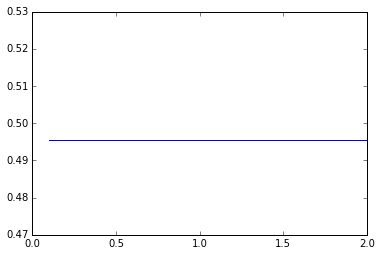

In [20]:
C_acc = []
for C_i in np.array(range(20))*0.1+np.ones(20)*0.1:
    svm_cls = svm.SVC(C = C_i)
    svm_cls.fit(df_train.ix[:,best_column_features], y_train)
    #Predicting
    y_pred = svm_cls.predict(df_test.ix[:,best_column_features])
    a = accuracy_score(y_true, y_pred)  
    C_acc.append([C_i,float(a)])
plt.plot(np.array(C_acc)[:,0],np.array(C_acc)[:,1])

## Tunning KNN

In [345]:
#Graph of tunning parameter versus testing error

## Defining Cross Validation Functions

In [25]:
df_train.ix[:,best_column_features].values

array([[  2.37000000e+02,   5.64063225e+02,   2.38875687e+02, ...,
          0.00000000e+00,   7.00000000e+00,   0.00000000e+00],
       [  6.30317383e+01,   1.20589947e+02,   2.00251323e+02, ...,
          2.00000000e+00,   2.00000000e+01,   1.00000000e+00],
       [  5.09215088e+01,   9.29826923e+02,   4.98230769e+02, ...,
         -4.00000000e+00,   6.00000000e+00,  -4.00000000e+00],
       ..., 
       [  1.08853111e+02,   1.06547938e+03,   3.53532990e+02, ...,
         -3.00000000e+00,   3.10000000e+01,  -4.00000000e+00],
       [  3.25576401e+01,   6.30236652e+02,   3.30221719e+01, ...,
          0.00000000e+00,   2.00000000e+01,   0.00000000e+00],
       [  2.97321377e+01,   6.76327300e+01,   3.94474359e+02, ...,
          6.30000000e+01,   1.52000000e+03,   5.80000000e+01]])

### Random Forest Cross Validation

In [217]:
sum(X.index.unique()==range(len(X.index)))

28758

In [286]:
len(y_train[train_y])

23965

In [314]:
##Define a function that would return the cross validation ROC_Array, Agg_Accuracy_Array, given a random forest model
X = df_train
y = y_train

def getROCandAccuracyOfCLF(forest_i,X,y,ROC=False):
    
    kf = cross_validation.KFold(len(X), n_folds=6,shuffle=True)
    #initialize the cv_labels_np_array

    cv_labels = np.array(range(len(y)))
    cv_score = np.ones((len(y),3))
    acc_array = []
    
    fpr_array = []
    
    tpr_array = []
    
    auc_array = []
    for train_index, test_index in kf:
        train_x = X.ix[train_index,best_column_features]
        train_y = y[train_index]

        test_x = X.ix[test_index,best_column_features]
        test_y = y[test_index]

        #Train the classifier
        #forest_i = random_forest(n_estimators = 1000, max_depth=50, min_samples_split=19, n_jobs =-1 )
        forest_i.fit(train_x, train_y)
        cv_labels = forest_i.predict(test_x)
        
        #Compute the accuracy
        acc_array.append(sum(test_y==cv_labels)/float(len(cv_labels)))
        if(ROC):
            #compute the ROC
            cv_score = forest_i.predict_proba(test_x)

            #TP TN
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            n_classes = forest_i.classes_
            for i in range(3):
                print n_classes[i]
                fpr[i], tpr[i], _ = roc_curve(test_y==n_classes[i], cv_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            fpr_array.append(fpr)
            tpr_array.append(tpr)

            auc_array.append(roc_auc)
        
    return fpr_array, tpr_array, auc_array, acc_array
    
        

In [315]:
forest = random_forest(n_estimators = 1000, max_depth=50, min_samples_split=19, n_jobs =-1 )
getROCandAccuracyOfCLF(forest, X,y)

([],
 [],
 [],
 [0.86501147506780718,
  0.85729188399749634,
  0.86250782390986858,
  0.86334237429584815,
  0.86250782390986858,
  0.85958689755894013])

In [287]:
#Read to run
#run in the lab then go to bin

from sklearn import cross_validation
X = df_train
y = y_train
kf = cross_validation.KFold(len(X), n_folds=6,shuffle=True)
len(kf)

print(kf)  

#initialize the cv_labels_np_array

cv_labels = np.array(range(len(y)))
cv_score = np.ones((len(y),3))

for train_index, test_index in kf:
    train_x = X.ix[train_index,best_column_features]
    train_y = y[train_index]
    
    test_x = X.ix[test_index,best_column_features]
    test_y = y[test_index]
    
    #Train the classifier
    forest = random_forest(n_estimators = 1000, max_depth=50, min_samples_split=19, n_jobs =-1 )
    forest.fit(train_x, train_y)
    
    cv_labels[test_index] = forest.predict(test_x)
    cv_score[test_index] = forest.predict_proba(test_x)
    
    

sklearn.cross_validation.KFold(n=28758, n_folds=6, shuffle=True, random_state=None)


In [296]:
sum(cv_labels==y)/float(len(y))

0.86181236525488558

In [186]:
cv_score = np.ones((len(y),3))

In [192]:
cv_score[[1,2]] = [[1,2,3],[1,2,3]]

In [247]:
cv_score

array([[ 0.00565757,  0.12344804,  0.87089438],
       [ 0.63783232,  0.35263341,  0.00953427],
       [ 0.98659605,  0.01217813,  0.00122581],
       ..., 
       [ 0.7014285 ,  0.29642152,  0.00214998],
       [ 0.83653477,  0.00461136,  0.15885388],
       [ 0.9427976 ,  0.04111542,  0.01608697]])

In [300]:
#running Random forest
forest = random_forest(n_estimators = 1000, max_depth=50, min_samples_split=19, n_jobs =-1 )
y_score_HOS = forest.fit(df_train.ix[:,best_column_features], y_train).predict_proba(df_test.ix[:,best_column_features])

1
2
3


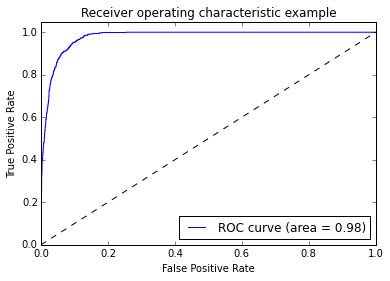

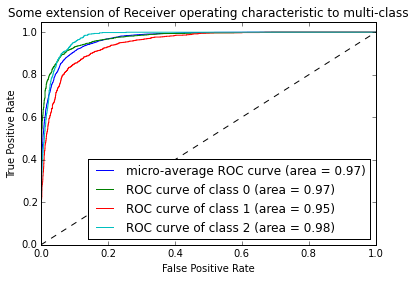

In [302]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

y_score = y_score_HOS


#Micro Averaging the y_true label matrix
y_true_micro_averaged = []
for y_true_i in y_true:
    y_true_micro_averaged.append([y_true_i==1,y_true_i==2,y_true_i==3])
    
# Run classifier with cross-validation and plot ROC curves
n_classes = forest.classes_

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = forest.classes_
for i in range(3):
    print n_classes[i]
    fpr[i], tpr[i], _ = roc_curve(y_true==n_classes[i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_true_micro_averaged).ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [239]:
#y_true = cv_labels
y_score = cv_score

In [244]:

len(cv_score)

28758

In [142]:
np.array(y_true_micro_averaged).ravel()

array([ True, False, False, ...,  True, False, False], dtype=bool)

In [292]:
float(len(y_train == cv_labels)/len(cv_labels))

1.0

In [310]:
len(y_train)/6.0

4793.0

In [304]:
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold


#Micro Averaging the y_true label matrix
y_true_micro_averaged = []
for y_true_i in y_train:
    y_true_micro_averaged.append([y_true_i==1,y_true_i==2,y_true_i==3])
    
# Run classifier with cross-validation and plot ROC curves
n_classes = forest.classes_

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = forest.classes_
for i in range(3):
    print n_classes[i]
    fpr[i], tpr[i], _ = roc_curve(y_train==n_classes[i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(y_true_micro_averaged).ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

1


ValueError: Found arrays with inconsistent numbers of samples: [ 3906 28758]

### SVM Cross Validation Accuracy

### KNN Cross Validation Accuracy

## Cross Validation Error of Random Forest

In [237]:
#running Random forest
forest = random_forest(n_estimators = 500, max_depth=50)
forest.fit(df_train, y_train)
#Predicting
y_pred = forest.predict(df_test)



In [205]:
y_pred = forest.predict(df_test)

In [213]:
y_pred =y_pred - ( y_pred>=4 )*3

In [280]:
#estimated error at the boundary
1570.0/sum(y_pred>=4)

0.45973645680819913

In [238]:
#estimated error in inner regions
sum((y_pred<4)*(y_pred ) == y_true)/ float(sum(y_pred<4))

0.99496764917325664

In [285]:
#estimated error in inner regions
sum((y_pred<4)*(y_pred ) == y_true)/ float(sum(y_pred<4))

0.97352342158859473

In [286]:
#estimated error in inner regions
sum((y_pred>=4)*(y_pred ) == y_true)/ float(sum(y_pred>=4))

0.0

In [281]:
sum(y_pred<4)/float(len(y_true))

0.12570404505888377

In [243]:
import seaborn as sns

In [268]:
#sns.distplot(np.array(y_pred[y_pred!=4]).ravel())
f = pd.DataFrame(np.array(y_pred[y_pred!=4]).ravel() , columns=['class'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x147018950>]], dtype=object)

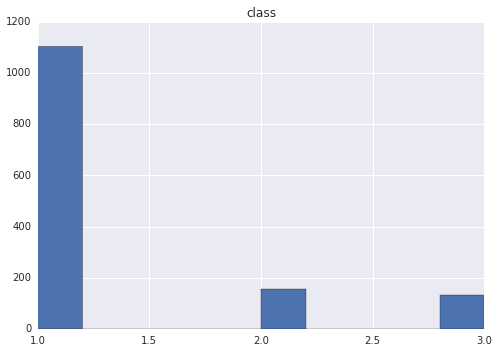

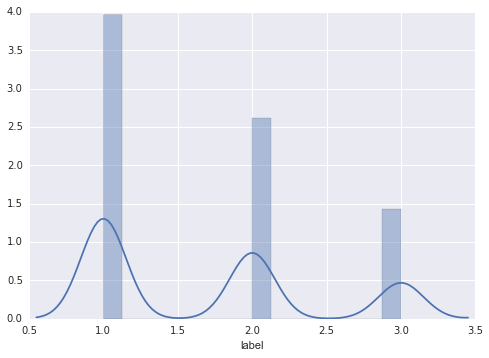

In [245]:
sns.distplot(y_true)

In [236]:
 sum((y_pred>=4)*(y_pred - ( y_pred>=4 )*3) == y_true)

767

In [191]:
y_pred

array([1, 1, 1, ..., 1, 2, 1])

In [72]:
#Forming a confusion matrix
cm = confusion_matrix(y_true,y_pred)
cm
#LOL the random int increased the accuracy by 1 percent!
accuracy_score(y_true, y_pred)

0.58013312852022525

In [155]:
df_train.columns

Index([u'Mean1', u'Mean2', u'Mean3', u'Mean4', u'Mean5', u'Mean6', u'Mean7',
       u'Mean8', u'Mean9', u'Mean10', u'Mean11', u'Mean12', u'Mean13',
       u'Median1', u'Median2', u'Median3', u'Median4', u'Median5', u'Median6',
       u'Median7', u'Median8', u'Median9', u'Median10', u'Median11',
       u'Median12', u'Median13', u'Variance1', u'Variance2', u'Variance3',
       u'Variance4', u'Variance5', u'Variance6', u'Variance7', u'Variance8',
       u'Variance9', u'Variance10', u'Variance11', u'Variance12',
       u'Variance13', u'Skewness1', u'Skewness2', u'Skewness3', u'Skewness4',
       u'Skewness5', u'Skewness6', u'Skewness7', u'Skewness8', u'Skewness9',
       u'Skewness10', u'Skewness11', u'Skewness12', u'Skewness13',
       u'Kurtosis1', u'Kurtosis2', u'Kurtosis3', u'Kurtosis4', u'Kurtosis5',
       u'Kurtosis6', u'Kurtosis7', u'Kurtosis8', u'Kurtosis9', u'Kurtosis10',
       u'Kurtosis11', u'Kurtosis12', u'Kurtosis13', u'x', u'y', u'distance',
       u'embryo_id'],
      dtyp

Feature ranking:
1. feature 2 (0.346807)Mean3
2. feature 1 (0.329378)Mean2
3. feature 0 (0.323815)Mean1


IndexError: index 3 is out of bounds for axis 0 with size 3

In [112]:
df_train.columns[36]

'Variance11'

In [170]:
df_train.head()

,Mean1,Mean2,Mean3,Mean4,Mean5,Mean6,Mean7,Mean8,Mean9,Mean10,...,Kurtosis7,Kurtosis8,Kurtosis9,Kurtosis10,Kurtosis11,Kurtosis12,Kurtosis13,x,y,distance
0,10,-103,0,9,7,0,0,0,0,-3,...,0,0,0,0,1,0,-1,564.063225,238.875687,237.000000
1,-6,-184,0,24,20,0,0,0,1,-4,...,0,0,0,0,0,0,0,120.589947,200.251323,63.031738
2,-14,-77,0,6,6,0,0,0,-4,-7,...,0,0,0,-1,5,-1,-1,929.826923,498.230769,50.921509
3,9,-132,0,29,25,0,0,0,4,-7,...,0,0,0,0,-1,0,0,195.250799,409.416933,100.239716
4,-13,-175,0,23,19,0,0,0,0,-7,...,0,0,0,0,0,2,2,735.015504,519.666667,73.437050


In [172]:
df_w = pd.DataFrame(W, columns=['weight'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1106339d0>]], dtype=object)

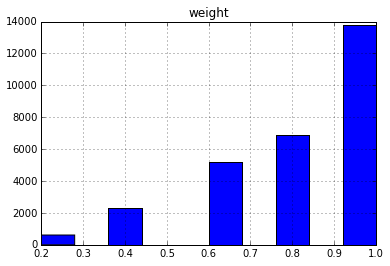

In [174]:
df_w.hist()

In [227]:
y_train.ix[W<=0.9] = 4

In [228]:
y_train

0        3
1        4
2        1
3        1
4        1
5        4
6        4
7        1
8        4
9        1
10       4
11       1
12       4
13       4
14       4
15       4
16       3
17       4
18       2
19       4
20       4
21       4
22       4
23       4
24       4
25       2
26       2
27       4
28       4
29       4
        ..
28728    4
28729    1
28730    4
28731    2
28732    2
28733    1
28734    3
28735    4
28736    3
28737    1
28738    4
28739    3
28740    1
28741    1
28742    3
28743    2
28744    4
28745    3
28746    1
28747    1
28748    4
28749    2
28750    4
28751    4
28752    1
28753    4
28754    4
28755    4
28756    4
28757    1
Name: label, dtype: int64

In [223]:
y_train_b = y_train[:]

In [287]:
y_train_2 = y_train_b[:]

In [289]:
y_train_2 = y_train_2 - (y_train_2>=4)*3

### I didn't prepare the following part for everyone's use yet, proceed with caution

In [9]:
kf = cross_validation.KFold(n = len(spatial_train), n_folds = 10, shuffle = True)

In [12]:
#k-folds
#Since the hyper parameters of random forest usually don't wary the accuracy that much, 
#i would use this for playing with the probability threshold for the best fit/ROC


for train_index, test_index in kf:
    X_train, X_test = spatial_train.ix[train_index,range(n_col)],
                      spatial_test.ix[test_index,range(n_col)]
    y_train, y_test = spatial_train.ix[train_index,-1], spatial_test[test_index,-1]
    #Do awesome training
    #Do awesome testing
    #Save awesome results for later

sklearn.cross_validation.KFold(n=28758, n_folds=10, shuffle=True, random_state=None)

In [18]:
len(spatial_train.columns)

4

In [25]:
spatial_train.ix[1:2,[0,1,2,3]]

,x,y,distance,label
1,120.589947,200.251323,63.031738,1
2,929.826923,498.230769,50.921509,1


In [26]:
range(4)

[0, 1, 2, 3]